# <font color="#003660">Applied Machine Learning for Text Analysis (M.184.5331)</font>


# <font color="#003660">Session 2: Document Classification/Regression with Neural Networks</font>

# <font color="#003660">Notebook 3: MLP with Word Embeddings as Features</font>

<center><br><img width=256 src="https://raw.githubusercontent.com/olivermueller/aml4ta-2021/main/resources/dag.png"/><br></center>

<p>
<center>
<div>
    <font color="#085986"><b>By the end of this lesson, you ...</b><br><br>
        ... are able to train a neural network with word embeddings as features.
    </font>
</div>
</center>
</p>

Instead of using word counts as features, we can also represent sentences as sequences of word embeddings. This results in a 2D data structure (sequence_length*embedding_dim). As "normal" neural networks cannot process such 2D tensors, we have to find a way to reduce the dimensionality of this structure.

# Import packages

As always, we first need to load a number of required Python packages:
- `pandas` provides high-performance, easy-to-use data structures and data analysis tools.
- `numpy` is a library adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.
- `sklearn` is a free software machine learning library for the Python programming language.
- `tensorflow` is an end-to-end open source platform for machine learning, especially deep learning.


In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from sklearn import metrics
import matplotlib.pyplot as plt

Check if we are running on GPU.

In [26]:
tf.config.experimental.list_physical_devices('GPU')

[]

# Load documents

Load wine reviews (Source: https://www.kaggle.com/datasets/zynicide/wine-reviews) from a csv file.

In [27]:
corpus = pd.read_csv("https://raw.githubusercontent.com/olivermueller/amlta-2024/main/Session_01/winemag-data-130k-v2.csv")

Split data into three sets: training, validation, and test.

In [29]:
training = corpus.iloc[0:80000,].sample(n=10000) # to speed up training
validation = corpus.iloc[80000:100000,]
test = corpus.iloc[100000:,]

For each dataset, store features and targets in separate variables

In [30]:
train_corpus_features = training[["description"]]
train_corpus_target = training[["points"]]
val_corpus_features = validation[["description"]]
val_corpus_target = validation[["points"]]
test_corpus_features = test[["description"]]
test_corpus_target = test[["points"]]

Create [TensorFlow `Datasets`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) from the Pandas dataframes. The use of TensorFlow Datasets follows a common pattern:

1.   Create a dataset from raw data (e.g., a Pandas dataframe, a CSV file, multiple text files).
2.   Apply transformations to preprocess the data in the dataset (e.g., tokenize and vectorize the texts).
3. Iterate over the dataset and process its elements. Iteration happens in a streaming fashion, so the full dataset does not need to fit into memory.

Here, we use the `from_tensor_slices` constructor to create datasets from dataframes.

In [31]:
train_ds = tf.data.Dataset.from_tensor_slices((tf.cast(train_corpus_features.values, tf.string),
                                               tf.cast(train_corpus_target.values, tf.int32)))

val_ds = tf.data.Dataset.from_tensor_slices((tf.cast(val_corpus_features.values, tf.string),
                                             tf.cast(val_corpus_target.values, tf.int32)))

test_ds = tf.data.Dataset.from_tensor_slices((tf.cast(test_corpus_features.values, tf.string),
                                              tf.cast(test_corpus_target.values, tf.int32)))

Display some stats and examples from the created datasets.

In [32]:
for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("===")
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (1,)
inputs.dtype: <dtype: 'string'>
targets.shape: (1,)
targets.dtype: <dtype: 'int32'>
===
inputs[0]: tf.Tensor(b'A blend of 60% Prokupac and 40% Cabernet Sauvignon this Serbian wine smells of red cherry and blackberry. It is full bodied, while tasting of black cherry and blackberry. The finish is fruit filled with a touch of leather.', shape=(), dtype=string)
targets[0]: tf.Tensor(89, shape=(), dtype=int32)


# Vectorize documents

We will now use [TensorFlow's `TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) function to transform raw texts into numerical vectors. **Instead of counting word appearances (like in the BOW model), we simply map words to integers (`output_mode = 'int'`) this time.** To get document representation of a fixed length, we limit the length of documents to 100 tokens (longer documents will be truncated, shorter documents will be padded with zeros).

In [33]:
max_tokens = 10000
max_length = 100

text_vectorization = TextVectorization(
    max_tokens = max_tokens,
    output_mode = "int",
    output_sequence_length = max_length
)

Some apects of the `TextVectorization` function (e.g., the size and contents of the vocabulary) have to be fit using training data, which can be done with the `adapt` function (which can only be applied to the features (x) of the dataset). 

In [34]:
train_ds_features_only = train_ds.map(lambda x, y: x)
text_vectorization.adapt(train_ds_features_only)

2024-10-28 20:15:34.818647: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Show the vocabulary that our vectorizer knows after being fit to the training data.

In [35]:
text_vectorization.get_vocabulary()[0:10]

['',
 '[UNK]',
 np.str_('and'),
 np.str_('the'),
 np.str_('a'),
 np.str_('of'),
 np.str_('with'),
 np.str_('this'),
 np.str_('is'),
 np.str_('wine')]

Next, we apply our `text_vectorization` function to all three datasets.

In [36]:
vectorized_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls = 4)

vectorized_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls = 4)

vectorized_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls = 4)

Show results.

In [37]:
for inputs, targets in vectorized_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("===")
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (1, 100)
inputs.dtype: <dtype: 'int64'>
targets.shape: (1,)
targets.dtype: <dtype: 'int32'>
===
inputs[0]: tf.Tensor(
[   4   49    5  844 9358    2  871   71   96    7 8740    9  478    5
   36   27    2   48   13    8   69  278   60  746    5   29   27    2
   48    3   21    8   16 1450    6    4   77    5  150    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(100,), dtype=int64)
targets[0]: tf.Tensor(89, shape=(), dtype=int32)


# Train model

We are now ready to specify a neural network and feed it with the vectroized datasets. For convenience, we define a custome function `get_model` which defines the network architecture, creates a model from it, and compiles this model (by defining, e.g., an otpimizer and loss function). Note that we have to somehow reduce the dimensionality of the output of the embedding layer (sequence_length*embedding_dim). Here, we simply perform a global average pooling (i.e., average each element of the embedding vector over all tokens).

In [38]:
def get_model(hidden_dim=32):
    inputs = keras.Input(shape=(max_length,), dtype="int64")
    embedded = layers.Embedding(input_dim=max_tokens, output_dim=300, mask_zero=True)(inputs)
    hidden1 = layers.GlobalAveragePooling1D()(embedded)
    hidden2 = layers.Dense(hidden_dim, activation = "relu")(hidden1)
    outputs = layers.Dense(1, activation = "linear")(hidden2)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer = tf.optimizers.Adam(),
                  loss = "mean_absolute_error",
                  metrics = ["mean_absolute_error"])
    return model

Instantiate model and show it's architecture.

In [39]:
model = get_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 300)  │  3,000,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 100)       │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 300)       │          0 │ embedding_1[0][0… │
│ (GlobalAveragePool… │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      9,632 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,009,665 (11.48 MB)

 Trainable params: 3,009,665 (11.48 MB)

 Non-trainable params: 0 (0.00 B)

Fit model on training data and save best model to disk. We use the validation set to monitor how the performance of the model evolves during training.

In [40]:
callbacks = [keras.callbacks.ModelCheckpoint("mlp.keras", save_best_only=True)]

history = model.fit(vectorized_train_ds.cache(),
          validation_data = vectorized_val_ds.cache(),
          epochs = 3,
          batch_size = 128,
          callbacks = callbacks)

Epoch 1/3
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - loss: 11.8201 - mean_absolute_error: 11.8201 - val_loss: 4.2988 - val_mean_absolute_error: 4.2988
Epoch 2/3
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - loss: 3.5588 - mean_absolute_error: 3.5588 - val_loss: 3.5126 - val_mean_absolute_error: 3.5126
Epoch 3/3
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - loss: 2.8931 - mean_absolute_error: 2.8931 - val_loss: 3.0375 - val_mean_absolute_error: 3.0375


Plot the learning process.

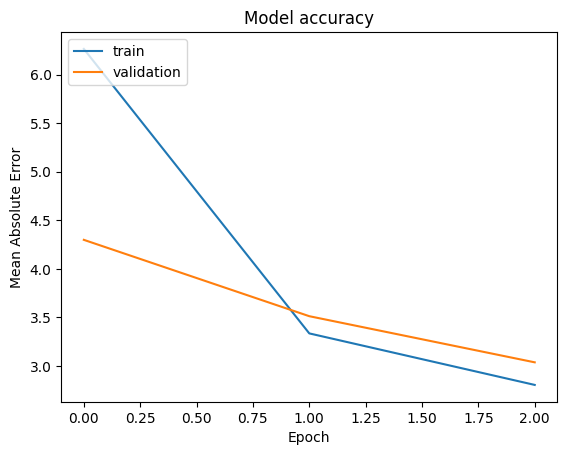

In [41]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model accuracy')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Make predictions

Load best model from training phase.

In [42]:
model = keras.models.load_model("mlp.keras")

Make predictions on test set.

In [43]:
preds = model.predict(vectorized_test_ds)

29971/29971 ━━━━━━━━━━━━━━━━━━━━ 12s 392us/step


Calculate accuracy metrics.

In [44]:
print(metrics.mean_absolute_error(test_corpus_target, preds))

3.030090980393596
